In [2]:
import kagglehub

# Download latest version
path = kagglehub.model_download("google/mobilenet-v2/tensorFlow2/100-224-feature-vector")

print("Path to model files:", path)

100%|██████████| 5.13k/5.13k [00:00<00:00, 1.58MB/s]



100%|██████████| 1.24M/1.24M [00:00<00:00, 1.60MB/s]
100%|██████████| 8.65M/8.65M [00:01<00:00, 6.69MB/s]

Path to model files: /home/miguel/.cache/kagglehub/models/google/mobilenet-v2/tensorFlow2/100-224-feature-vector/2


# 1. Data Exploration and feature extraction

From the documentation we see that:
"The input images are expected to have color values in the range [0,1], following the common image input conventions. For this model, the size of the input images is fixed to height x width = 224 x 224 pixels."

In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and scaling
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)  # Adjust rescaling if needed
train_data = datagen.flow_from_directory('./train', target_size=image_size, batch_size=batch_size)
valid_data = datagen.flow_from_directory('./valid', target_size=image_size, batch_size=batch_size)
test_data = datagen.flow_from_directory('./test', target_size=image_size, batch_size=batch_size)


Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


In [14]:
categories = list(valid_data.class_indices.keys())
categories

['bike', 'car', 'motorcycle', 'other', 'truck', 'van']

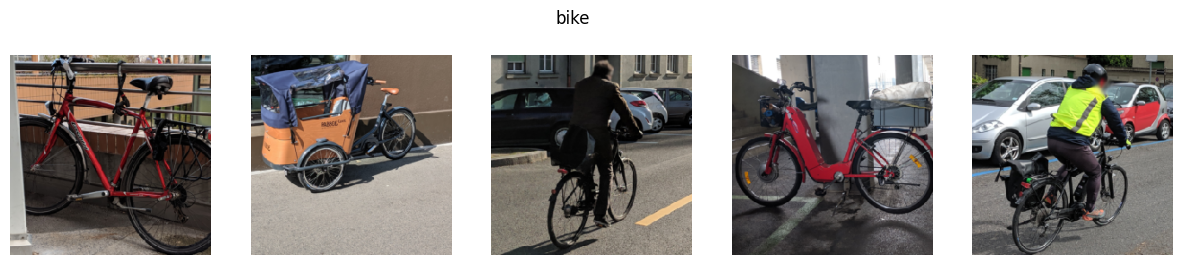

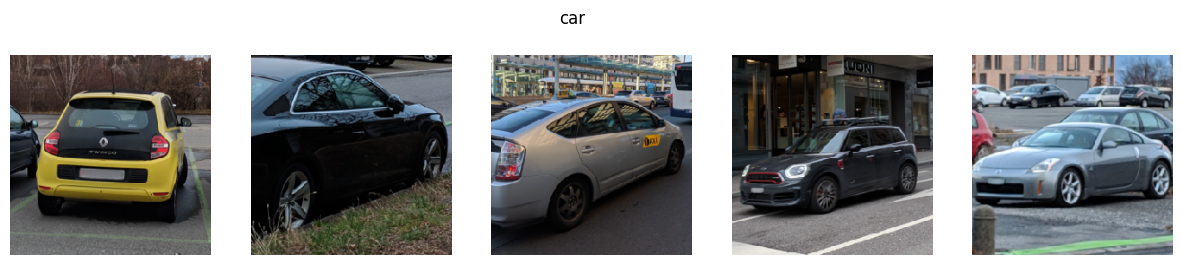

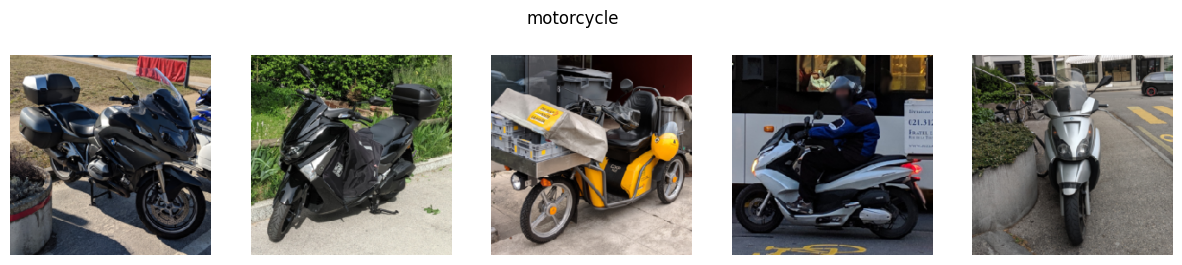

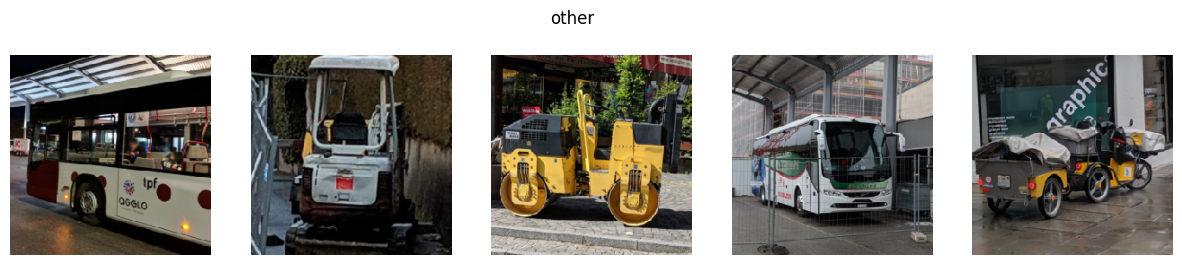

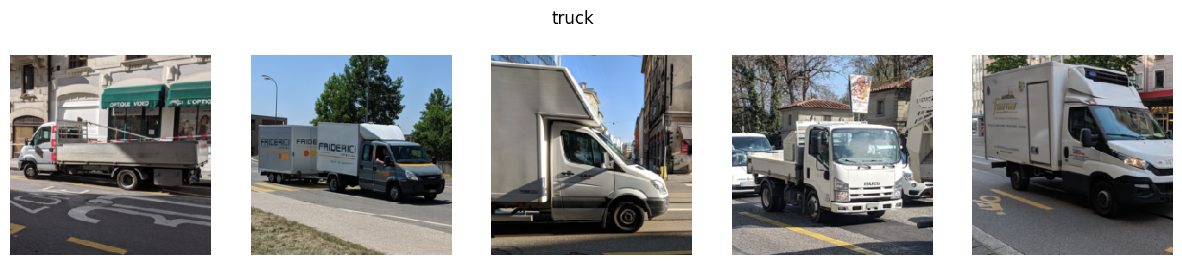

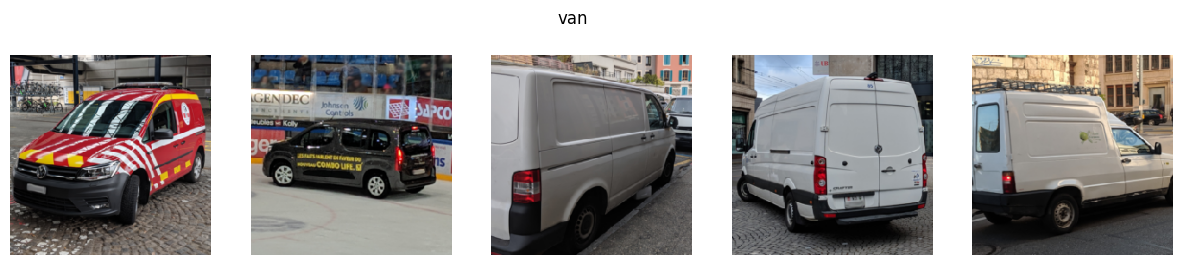

In [17]:
import matplotlib.pyplot as plt

def plot_samples(data, category):
    
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(category)
    
    k=0
    while k<5:

        images, labels = next(iter(data))
    
        for n,label in enumerate(labels):
            if label[categories.index(category)] == 1:
                axes[k].imshow(images[n]) 
                axes[k].axis('off')
                k+=1
                if k==5:
                    break

categories = ['bike', 'car', 'motorcycle', 'other', 'truck', 'van']
for category in categories:
    plot_samples(train_data, category)


In [32]:

train_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5], dtype=int32)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 │   plt.ylabel("Frequncy")                                                                  │
│   12 │   plt.show()                                                                              │
│   13                                                                                             │
│ ❱ 14 plot_category_distribution(train_data, "Training Set Distribution")                         │
│   15 plot_category_distribution(valid_data, "Validation Set Distribution")                       │
│   16 plot_category_distribution(test_data, "Test Set Distribution")                              │
│   17                                                                                             │
│                                                                                                  │
│ in plot_category_distribution:8                                                                  │
│                                                                                                  │
│    5 │   category_counts = data.classes                                                          │
│    6 │   category_names = list(data.class_indices.keys())                                        │
│    7 │                                                                                           │
│ ❱  8 │   sns.histplot(category_counts,binwidth=1, normalize=True)                                │
│    9 │   plt.title(title)                                                                        │
│   10 │   plt.xlabel("Category")                                                                  │
│   11 │   plt.ylabel("Frequncy")                                                                  │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/seaborn/ │
│ distributions.py:1422 in histplot                                                                │
│                                                                                                  │
│   1419 │                                                                                         │
│   1420 │   if p.univariate:                                                                      │
│   1421 │   │                                                                                     │
│ ❱ 1422 │   │   p.plot_univariate_histogram(                                                      │
│   1423 │   │   │   multiple=multiple,                                                            │
│   1424 │   │   │   element=element,                                                              │
│   1425 │   │   │   fill=fill,                                                                    │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/seaborn/ │
│ distributions.py:508 in plot_univariate_histogram                                                │
│                                                                                                  │
│    505 │   │   │   │   │   else:                                                                 │
│    506 │   │   │   │   │   │   artist = mpl.patches.Rectangle                                    │
│    507 │   │   │   │   │   │   plot_kws = _normalize_kwargs(plot_kws, artist)                    │
│ ❱  508 │   │   │   │   │   │   scout = self.ax.fill_between([], [], color=color, **plot_kws)     │
│    509 │   │   │   │   │   │   default_color = tuple(scout.

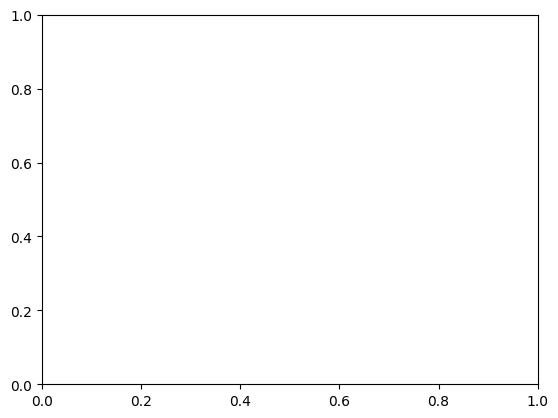

In [37]:
import pandas as pd
import seaborn as sns

def plot_category_distribution(data, title):
    category_counts = data.classes
    category_names = list(data.class_indices.keys())

    sns.histplot(category_counts,binwidth=1, normalize=True)
    plt.title(title)
    plt.xlabel("Category")
    plt.ylabel("Frequncy")
    plt.show()

plot_category_distribution(train_data, "Training Set Distribution")
plot_category_distribution(valid_data, "Validation Set Distribution")
plot_category_distribution(test_data, "Test Set Distribution")


In [4]:
validset.class_indices == trainset.class_indices == testset.class_indices

True

['bike', 'car', 'motorcycle', 'other', 'truck', 'van']

In [7]:
image, label = trainset[0]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:9                                                                                    │
│                                                                                                  │
│    6                                                                                             │
│    7 for i, category in enumerate(categories):                                                   │
│    8 │   for j in range(3):                                                                      │
│ ❱  9 │   │   axes[i, j].imshow(trainset[category][j])                                            │
│   10 │   │   axes[i, j].set_title(f"{category}")                                                 │
│   11 │   │   axes[i, j].axis('off')                                                              │
│   12                                                                                             │
│                                                                                                  │
│ /home/miguel/.pyenv/versions/3.9/envs/epfl_extension_school/lib/python3.9/site-packages/keras_pr │
│ eprocessing/image/iterator.py:53 in __getitem__                                                  │
│                                                                                                  │
│    50 │   │   │   self.index_array = np.random.permutation(self.n)                               │
│    51 │                                                                                          │
│    52 │   def __getitem__(self, idx):                                                            │
│ ❱  53 │   │   if idx >= len(self):                                                               │
│    54 │   │   │   raise ValueError('Asked to retrieve element {idx}, '                           │
│    55 │   │   │   │   │   │   │    'but the Sequence '                                           │
│    56 │   │   │   │   │   │   │    'has length {length}'.format(idx=idx,                         │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: '>=' not supported between instances of 'str' and 'int'

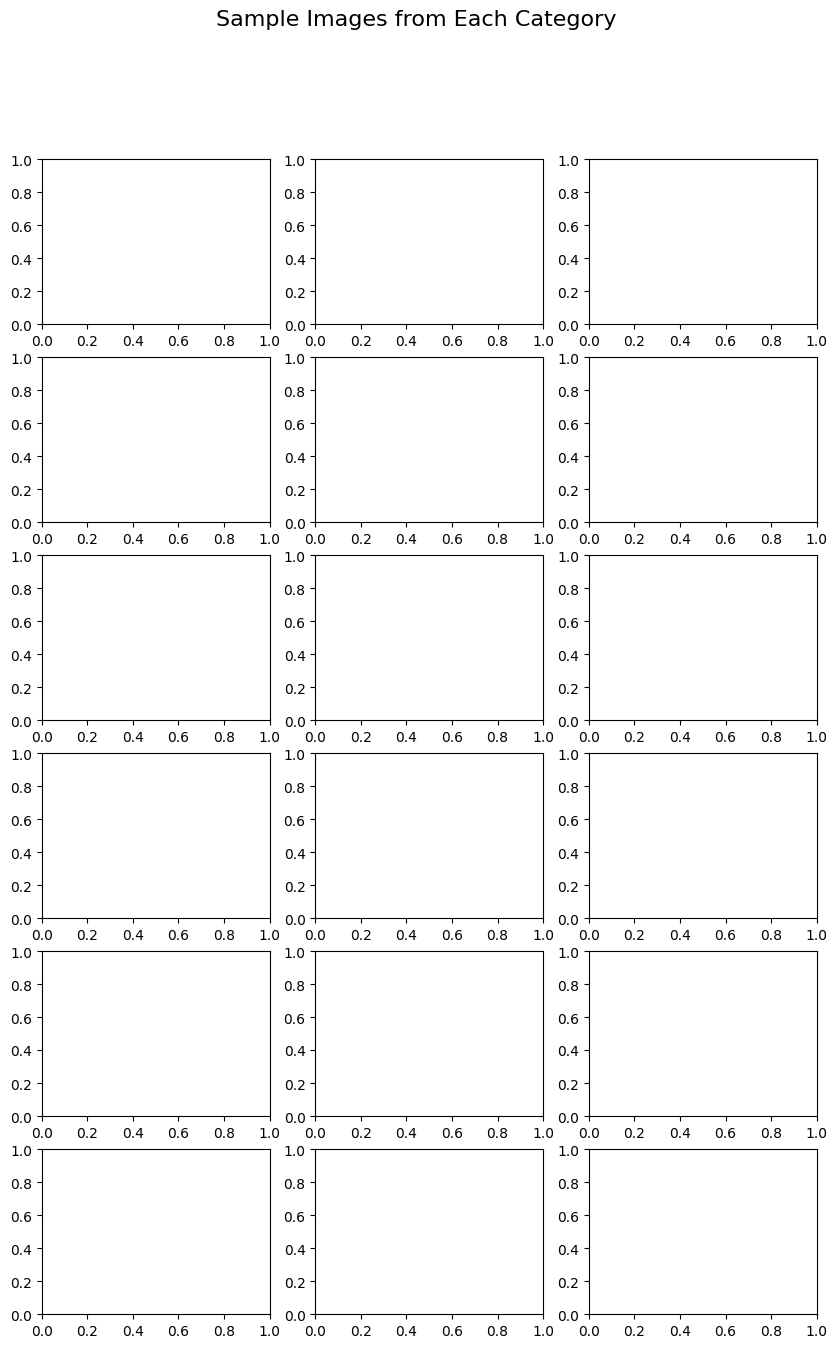

In [8]:
from matplotlib import pyplot as plt

# Plot images
fig, axes = plt.subplots(len(categories), 3, figsize=(10, 15))
fig.suptitle("Sample Images from Each Category", fontsize=16)

for i, category in enumerate(categories):
    for j in range(3):
        axes[i, j].imshow(trainset[category][j])
        axes[i, j].set_title(f"{category}")
        axes[i, j].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()